# Aggregate Air Quality Data to DHIS2 Organisation Units in Sri Lanka

In this notebook we will show how to load daily air quality data from NetCDF using [earthkit](https://ecmwf.github.io/earthkit-website/) and aggregate the data to DHIS2 organisation units (districts) in Sri Lanka. 

### Step 1: Importing basic libraries

In [ ]:
# --- Step 1: Importing basic libraries ---
import pandas as pd             # tabular data, time series, CSV I/O
import xarray as xr             # labeled N-D arrays (perfect for NetCDF)
import numpy as np              # fast numeric ops

# plotting
import matplotlib.pyplot as plt # quick maps/plots

# climate tools stack
import earthkit.data            # opens files (NetCDF, GeoJSON) as earthkit sources
from earthkit.transforms import aggregate  # spatial aggregation to polygons

import sys                      # query Python version & paths
import os                       # environment variables, paths
print("Python:", sys.version)
%who module                     # Jupyter magic: list currently imported modules

### Step 2: Loading data

In [ ]:
# --- Step 2: Loading data ---

file = r".....\file_name.nc" # 🔹 Ad corect path to the file

# Open the dataset using Earthkit
try:
    data = earthkit.data.from_source("file", file)
    print("File loaded successfully:", file)
except Exception as e:
    print("⚠️ Error loading file:", e)
    
# Convert to xarray Dataset
ds = data.to_xarray()

# Display summary in Jupyter
display(ds)

# Show available variables and coordinates
print("Variables:", list(ds.data_vars))
print("Coordinates:", list(ds.coords))
print("Time range:", str(ds.time.values[0]), "to", str(ds.time.values[-1]))

### Step 3: Preparing and inspecting variables

In [ ]:
# --- Step 3: Preparing and inspecting variables ---

# Rename the anonymous variable to a meaningfull variable name
ds = ds.rename({"__xarray_dataarray_variable__": "pm25"})

# ensure time is datetime + sorted
if "time" in ds.coords:
    ds["time"] = pd.to_datetime(ds["time"].values)
    ds = ds.sortby("time")

# Quick look at values and metadata
print("DataArray summary:")
print(ds.pm25)
print("Min:", float(ds.pm25.min().compute()))
print("Max:", float(ds.pm25.max().compute()))
print("Completed.")

### Step 4: Visualize data as a map

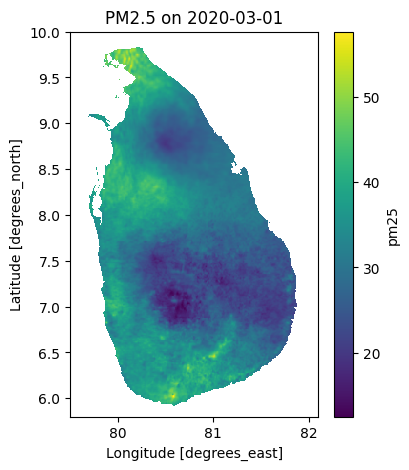

In [4]:
# --- Step 4: Visualize data as a map ---

import rioxarray  # step-specific: enables .rio accessor

# Sri Lanka bbox
lat_min, lat_max = 5.8, 10.2
lon_min, lon_max = 79.5, 82.1

pm = ds.pm25
if not pm.rio.crs:
    pm = pm.rio.write_crs(4326)

# Subset to bbox (handles ascending/descending lat)
lat_slice = slice(lat_min, lat_max) if pm.lat[0] < pm.lat[-1] else slice(lat_max, lat_min)
pm_sl = pm.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# Pick and plot first day (fallback to nearest if exact match fails)
try:
    day = pd.to_datetime(pm_sl.time.values[0]).date()
    to_plot = pm_sl.sel(time=str(day))
except Exception:
    to_plot = pm_sl.isel(time=0)
    day = pd.to_datetime(pm_sl.time.values[0]).date()

ax = to_plot.plot(figsize=(4,5))
ax.axes.set_title(f"PM2.5 on {day}")
plt.show()

### Step 5: Visualize data as a time series

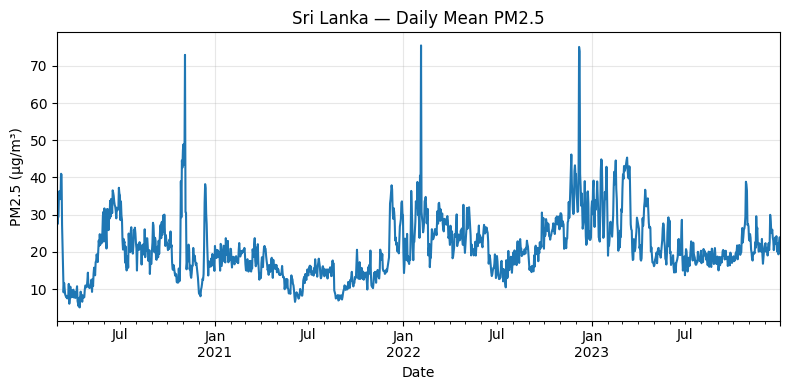

In [5]:
# ---- Step 5: Visualize data as a time series ----

pm = ds["pm25"]

# Ensure we have standard coord names (adjust if yours are 'lat'/'lon')
lat_name = "latitude" if "latitude" in pm.coords else "lat"
lon_name = "longitude" if "longitude" in pm.coords else "lon"

# Sri Lanka bounding box
lat_min, lat_max = 5.8, 10.2
lon_min, lon_max = 79.5, 82.1

# Subset to SL (auto-handle ascending/descending latitude)
lat_vals = pm[lat_name].values
lat_slice = slice(lat_min, lat_max) if lat_vals[0] < lat_vals[-1] else slice(lat_max, lat_min)
pm_sl = pm.sel({lat_name: lat_slice, lon_name: slice(lon_min, lon_max)})

# Compute spatial mean (ignoring NaNs) for each time step
# Result is a 1D DataArray indexed by time
ts = pm_sl.mean(dim=[lat_name, lon_name], skipna=True)

# Convert to a tidy pandas Series
ts = ts.to_series()
ts.index = pd.to_datetime(ts.index)

# OPTIONAL: smooth or resample (daily mean should already be daily)
# monthly = ts.resample("MS").mean()

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ts.plot(ax=ax)
ax.set_title("Sri Lanka — Daily Mean PM2.5")
ax.set_xlabel("Date")
ax.set_ylabel("PM2.5 (µg/m³)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Step 6: Getting organization units from DHIS2

In [ ]:
# ---- Step 6: Getting organization units from DHIS2 ----

import requests
import geopandas as gpd
from shapely.geometry import shape

BASE = "https://......"  # 🔹 add url with no trailing slash
USER = "user" # 🔹 add username
PASS = "pass" # 🔹 add password
OU_LEVEL = 3   # fetch org units at district level (change level if your districts use another level)

r = requests.get(
    f"{BASE.rstrip('/')}/api/organisationUnits.json",
    params={"fields": "id,name,geometry", "paging": "false", "level": OU_LEVEL},
    auth=(USER, PASS),
    timeout=120
)
r.raise_for_status()
units = r.json().get("organisationUnits", [])
polys = [u for u in units if u.get("geometry") and u["geometry"].get("type") in ("Polygon","MultiPolygon")]

gdf_districts = gpd.GeoDataFrame(
    [{"id": u["id"], "name": u["name"], "geometry": shape(u["geometry"])} for u in polys],
    crs="EPSG:4326"
)
print(f"Loaded {len(gdf_districts)} districts with geometry at level {OU_LEVEL}.")
gdf_districts.head()

Loaded 26 districts with geometry at level 3.


,id,name,geometry
0,Z2RsgSDpXVp,Ampara RDHS,"MULTIPOLYGON (((81.6958 7.2654, 81.6993 7.2604..."
1,Jns2a9OHqWL,Anuradhapura RDHS,"POLYGON ((80.9411 8.3424, 80.9321 8.3462, 80.9..."
2,tmYbVNQz6uy,Badulla RDHS,"POLYGON ((81.2708 7.278, 81.2684 7.2774, 81.26..."
3,a7Gms6C9rXA,Batticaloa RDHS,"POLYGON ((81.4036 8.2655, 81.4066 8.2549, 81.4..."
4,jHziKXGUJG0,Colombo RDHS,"POLYGON ((80.1784 6.9786, 80.1827 6.9759, 80.1..."


In [7]:
# show every row without truncation
pd.set_option('display.max_rows', None)
display(gdf_districts[['id','name']].sort_values('name').reset_index(drop=True))

print("Total districts:", len(gdf_districts))

,id,name
0,Z2RsgSDpXVp,Ampara RDHS
1,Jns2a9OHqWL,Anuradhapura RDHS
2,tmYbVNQz6uy,Badulla RDHS
3,a7Gms6C9rXA,Batticaloa RDHS
4,jHziKXGUJG0,Colombo RDHS
5,kVh9DoyXRwK,Galle RDHS
6,rrPMoH1VER7,Gampaha RDHS
7,rIOqxbZXvyn,Hambantota RDHS
8,Z4W1xSESZcF,Jaffna RDHS
9,n45tpDJZqAb,Kalmunai RDHS


Total districts: 26


### Step 7: Aggregating air quality data for DHIS2 organization units

In [8]:
# ---- Step 7: Aggregating air quality data for DHIS2 organization units ----

import json, tempfile
from shapely.geometry import mapping

print("Please be patience. This steps takes a few minutes...")

# Build a FeatureCollection from gdf_districts with top-level feature.id = orgUnit UID
features_fc = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "id": row["id"],  # important: matches mask_dim="id"
            "properties": {"name": row["name"]},
            "geometry": mapping(row["geometry"])
        }
        for _, row in gdf_districts.iterrows()
        if row["geometry"] is not None and not row["geometry"].is_empty
    ]
}

# Write to a temp file, load with earthkit, then delete
with tempfile.NamedTemporaryFile(suffix=".geojson", delete=False, mode="w", encoding="utf-8") as tmp:
    json.dump(features_fc, tmp)
    tmp_path = tmp.name

try:
    features = earthkit.data.from_source("file", tmp_path)

    pm = ds["pm25"]
    # (optional) subset to SL bbox
    lat = "latitude" if "latitude" in pm.coords else "lat"
    lon = "longitude" if "longitude" in pm.coords else "lon"
    pm_sl = pm.sel({lat: slice(5.8, 10.2), lon: slice(79.5, 82.1)})

    agg_ds = aggregate.spatial.reduce(pm_sl.to_dataset(name="pm25"), features, mask_dim="id")
    agg_df = (agg_ds.to_dataframe()
                      .reset_index()
                      .rename(columns={"id":"orgUnit","time":"date","pm25":"value"}))
    agg_df["date"] = pd.to_datetime(agg_df["date"])
    agg_df["period"] = agg_df["date"].dt.strftime("%Y%m%d")
    agg_df["value"] = pd.to_numeric(agg_df["value"], errors="coerce").round(2)
    agg_df = agg_df.dropna(subset=["value"])
finally:
    try:
        os.remove(tmp_path)
    except Exception:
        pass

print("Rows:", len(agg_df),
      "| Districts:", agg_df["orgUnit"].nunique(),
      "| Days:", agg_df["date"].dt.date.nunique())
display(agg_df.head())
print("Task completed")

Please be patience. This steps takes a few minutes...
Rows: 36426 | Districts: 26 | Days: 1401


,date,orgUnit,value,period
0,2020-03-01,Z2RsgSDpXVp,23.94,20200301
1,2020-03-01,Jns2a9OHqWL,34.77,20200301
2,2020-03-01,tmYbVNQz6uy,23.86,20200301
3,2020-03-01,a7Gms6C9rXA,27.42,20200301
4,2020-03-01,jHziKXGUJG0,35.94,20200301


Task completed


### Step 8: Import aggregated PM₂.₅ values to DHIS2

In [ ]:
# --- Step 8: Import aggregated PM₂.₅ values to DHIS2 ---

from dhis2eo.integrations.pandas import dataframe_to_dhis2_json
from dhis2_client import DHIS2Client
from dhis2_client.settings import ClientSettings

# define DHIS2 connection
BASE = os.getenv("DHIS2_BASE", "https://..............") # 🔹 add url with no trailing slash
USER = os.getenv("DHIS2_USER", "user") # 🔹 add username
PASS = os.getenv("DHIS2_PASS", "pass") # 🔹 add password

DE_PM25_UID = "data_element_UID" # 🔹 add data element UID

# Convert DataFrame to DHIS2 JSON payload
payload = dataframe_to_dhis2_json(
    df=agg_df,
    org_unit_col="orgUnit",
    period_col="period",
    value_col="value",
    data_element_id=DE_PM25_UID
)
print("Payload created successfully.")
print("Data values in payload:", len(payload["dataValues"]))
print("Example:", payload["dataValues"][:1])

# Connect to dhis2 API
client = DHIS2Client(settings=ClientSettings(
    base_url=BASE.rstrip("/"),
    username=USER,
    password=PASS,
    timeout=120,   # seconds (try 120–300)
    retries=2      # 2–3 light retries for transient issues
))
print("Connection to dhis2 instance established.")
print("Connected to DHIS2:", client.get_system_info()["contextPath"])

# import PM2.5 data to dhis2 in batches
BATCH_SIZE = 5000

for i in range(0, len(payload["dataValues"]), BATCH_SIZE):
    chunk = {"dataValues": payload["dataValues"][i:i + BATCH_SIZE]}
    resp = client.post("/api/dataValueSets", json=chunk)

    # The client returns a dict, so check for 'status' or 'response' keys
    if isinstance(resp, dict):
        status = resp.get("status") or resp.get("httpStatusCode") or "UNKNOWN"
        count = resp["response"].get("importCount", resp["response"])
        print(f"Batch {i+1}-{i+len(chunk['dataValues'])}: {status} {count}")
    else:
        print(f"Batch {i+1}-{i+len(chunk['dataValues'])}: Unknown response type:", type(resp))
print("Importing data to dhis2 completed")


### Step 9: Validate imported data in DHIS2

In [ ]:
# --- Step 9: Validate imported data in DHIS2 ---

import requests

BASE = "https://........" # 🔹 add url
USER, PASS = "user", "pass" # 🔹 add username, password
DE, OU, PE = "data_elemet_UID", "org_unit_UID", "20200301" # 🔹 add UIDs and period (date)

r = requests.get(f"{BASE}/api/dataValues", params={"de": DE, "ou": OU, "pe": PE}, auth=(USER, PASS))
print("Receiving the value for DE:", DE, ", OU:", OU, ", PE:", PE, "from ", BASE)
if r.status_code == 200:
    print("Value:", r.text)   # e.g., '23.6'
    print("Data import validation successful.")
elif r.status_code == 404:
    print("No value stored for this DE/OU/PE.")
else:
    print(r.status_code, r.text[:300])


### Step 10: Check population raster files

(Population rasters can be downloaded from https://hub.worldpop.org/geodata/listing?id=136)

In [ ]:
# Register population rasters by year ---

import rioxarray

pop_files = {
    2021: r"......\population data\lka_pop_2021_CN_1km_R2025A_UA_v1.tif", # 🔹 add corect file path
    2022: r"......\population data\lka_pop_2022_CN_1km_R2025A_UA_v1.tif", # 🔹 add corect file path
    2023: r"......\population data\lka_pop_2023_CN_1km_R2025A_UA_v1.tif"  # 🔹 add corect file path
}

print("Population rasters:")
for y, p in pop_files.items():
    print(" ", y, "→", os.path.basename(p), "| exists:", os.path.exists(p))

Population rasters:
  2021 → lka_pop_2021_CN_1km_R2025A_UA_v1.tif | exists: True
  2022 → lka_pop_2022_CN_1km_R2025A_UA_v1.tif | exists: True
  2023 → lka_pop_2023_CN_1km_R2025A_UA_v1.tif | exists: True


### Step 11: Loading necessary libraries and functions

In [12]:
# Step-specific imports
import os, json, tempfile, numpy as np, pandas as pd, xarray as xr, rioxarray
import requests, geopandas as gpd
from shapely.geometry import shape, mapping
import earthkit.data
from earthkit.transforms import aggregate

# Function to load & align population raster to the PM grid
def load_pop_for_year(pop_file, pm_reference):
    """Open population raster and align it to the PM grid."""
    pop = rioxarray.open_rasterio(pop_file).squeeze(drop=True)  # drop band dim if present

    if not pop.rio.crs:
        pop = pop.rio.write_crs(4326)

    # Reproject/resample to match PM grid
    pop_match = pop.rio.reproject_match(pm_reference)

    # Rename coords to match PM (lat/lon)
    rename_map = {}
    if "y" in pop_match.coords: rename_map["y"] = "latitude" if "latitude" in pm_reference.coords else "lat"
    if "x" in pop_match.coords: rename_map["x"] = "longitude" if "longitude" in pm_reference.coords else "lon"
    if rename_map: pop_match = pop_match.rename(rename_map)

    print("Aligned pop shape:", tuple(pop_match.shape))
    print("Pop min/max:", float(np.nanmin(pop_match)), "/", float(np.nanmax(pop_match)))
    return pop_match

### Step 12: Fetch districts from DHIS2

In [ ]:
# Define variables
BASE = "https://......." # 🔹 add correct URL
USER = "user" # 🔹 add username
PASS = "pass" # 🔹 add password
OU_LEVEL = 3  # district level

print("WorldPop files:")
for y, p in pop_files.items():
    print(f"  {y}: {os.path.basename(p)} | exists={os.path.exists(p)}")

# Fetch districts from DHIS2
print("\nFetching DHIS2 districts…")
r = requests.get(
    f"{BASE.rstrip('/')}/api/organisationUnits.json",
    params={"fields": "id,name,geometry", "paging": "false", "level": OU_LEVEL},
    auth=(USER, PASS), timeout=120
)
r.raise_for_status()
units = r.json().get("organisationUnits", [])
polys = [u for u in units if u.get("geometry") and u["geometry"].get("type") in ("Polygon","MultiPolygon")]
gdf_districts = gpd.GeoDataFrame(
    [{"id": u["id"], "name": u["name"], "geometry": shape(u["geometry"])} for u in polys],
    crs="EPSG:4326"
)
print(f"✓ Loaded {len(gdf_districts)} districts at level {OU_LEVEL}.")
display(gdf_districts[['id','name']].sort_values('name').head())

WorldPop files:
  2021: lka_pop_2021_CN_1km_R2025A_UA_v1.tif | exists=True
  2022: lka_pop_2022_CN_1km_R2025A_UA_v1.tif | exists=True
  2023: lka_pop_2023_CN_1km_R2025A_UA_v1.tif | exists=True

Fetching DHIS2 districts…
✓ Loaded 26 districts at level 3.


,id,name
0,Z2RsgSDpXVp,Ampara RDHS
1,Jns2a9OHqWL,Anuradhapura RDHS
2,tmYbVNQz6uy,Badulla RDHS
3,a7Gms6C9rXA,Batticaloa RDHS
4,jHziKXGUJG0,Colombo RDHS


### Step 13: Ensure PM grid has CRS + spatial dimsensions

In [14]:
# Ensure PM grid has CRS + spatial dims (needed for reproject_match)
pm_full = ds["pm25"]  # uses your dataset from earlier steps
lat = "latitude" if "latitude" in pm_full.coords else ("lat" if "lat" in pm_full.coords else None)
lon = "longitude" if "longitude" in pm_full.coords else ("lon" if "lon" in pm_full.coords else None)
assert lat and lon, "Could not find latitude/longitude coordinate names."

if not pm_full.rio.crs:
    pm_full = pm_full.rio.write_crs(4326)
if getattr(pm_full.rio, "x_dim", None) != lon or getattr(pm_full.rio, "y_dim", None) != lat:
    pm_full = pm_full.rio.set_spatial_dims(x_dim=lon, y_dim=lat, inplace=False)

pm_ref = pm_full.isel(time=0)  # reference grid for matching
print("PM ref → shape:", tuple(pm_ref.shape), "| CRS:", pm_ref.rio.crs, "| dims:", pm_ref.dims)

PM ref → shape: (450, 450) | CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] | dims: ('lat', 'lon')


### Step 14: Build a temp GeoJSON FeatureCollection

In [15]:
# Build a temp GeoJSON FeatureCollection (feature.id = orgUnit UID) for Earthkit
features_fc = {
    "type": "FeatureCollection",
    "features": [
        {"type":"Feature","id":row["id"],"properties":{"name":row["name"]},"geometry":mapping(row["geometry"])}
        for _, row in gdf_districts.iterrows()
        if row["geometry"] is not None and not row["geometry"].is_empty
    ]
}
with tempfile.NamedTemporaryFile(suffix=".geojson", delete=False, mode="w", encoding="utf-8") as tmp:
    json.dump(features_fc, tmp)
    features_path = tmp.name
features = earthkit.data.from_source("file", features_path)

# Helper: load & align WorldPop to PM grid
def load_pop_for_year(pop_file, pm_reference):
    pop = rioxarray.open_rasterio(pop_file).squeeze(drop=True)
    if not pop.rio.crs:
        pop = pop.rio.write_crs(4326)
    # Ensure pm_reference has CRS + spatial dims (belt & braces)
    if not pm_reference.rio.crs:
        pm_reference = pm_reference.rio.write_crs(4326)
    latr = "latitude" if "latitude" in pm_reference.coords else "lat"
    lonr = "longitude" if "longitude" in pm_reference.coords else "lon"
    if getattr(pm_reference.rio, "x_dim", None) != lonr or getattr(pm_reference.rio, "y_dim", None) != latr:
        pm_reference = pm_reference.rio.set_spatial_dims(x_dim=lonr, y_dim=latr, inplace=False)

    pop_match = pop.rio.reproject_match(pm_reference)
    # rename coords to match PM naming
    ren = {}
    if "y" in pop_match.coords: ren["y"] = latr
    if "x" in pop_match.coords: ren["x"] = lonr
    if ren: pop_match = pop_match.rename(ren)
    if getattr(pop_match.rio, "x_dim", None) != lonr or getattr(pop_match.rio, "y_dim", None) != latr:
        pop_match = pop_match.rio.set_spatial_dims(x_dim=lonr, y_dim=latr, inplace=False)
    print("  aligned POP →", tuple(pop_match.shape), "| CRS:", pop_match.rio.crs)
    return pop_match

### Step 15: Compute PW means year-by-year

In [16]:
# Compute PW means year-by-year using Earthkit (sum reducer)
lat_min, lat_max = 5.8, 10.2
lon_min, lon_max = 79.5, 82.1

dfs = []
for year, pop_file in pop_files.items():
    print(f"\nYear {year}…")
    # Subset PM to this year and bbox
    pm_y = pm_full.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    lat_vals = pm_y[lat].values
    lat_slice = slice(lat_min, lat_max) if lat_vals[0] < lat_vals[-1] else slice(lat_max, lat_min)
    pm_y = pm_y.sel({lat: lat_slice, lon: slice(lon_min, lon_max)})
    print("  PM subset:", tuple(pm_y.shape), "(time, lat, lon)")

    # Align population to PM grid & subset
    pop = load_pop_for_year(pop_file, pm_ref)
    pop = pop.sel({lat: lat_slice, lon: slice(lon_min, lon_max)})

    # Broadcast POP across time
    pop_b = pop.broadcast_like(pm_y)

    # Build numerator/denominator datasets
    num = (pm_y * pop_b).to_dataset(name="num")
    den = pop_b.to_dataset(name="den")
    both = xr.merge([num, den], compat="override")

    # Aggregate sums over districts (mask_dim='id' uses feature.id)
    agg_sum = aggregate.spatial.reduce(both, features, mask_dim="id", how="sum")
    df = agg_sum.to_dataframe().reset_index()  # columns: id, time, num, den
    df = df.rename(columns={"id":"orgUnit","time":"date"})
    df["value"] = (df["num"] / df["den"]).round(2)
    df = df.drop(columns=["num","den"])
    df["date"] = pd.to_datetime(df["date"])
    df["period"] = df["date"].dt.strftime("%Y%m%d")
    df = df.dropna(subset=["value","orgUnit","period"]).reset_index(drop=True)
    print("  rows:", len(df), "| districts:", df["orgUnit"].nunique(), "| days:", df["date"].dt.date.nunique())
    dfs.append(df)


Year 2021…
  PM subset: (365, 420, 260) (time, lat, lon)
  aligned POP → (450, 450) | CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
  rows: 9490 | districts: 26 | days: 365

Year 2022…
  PM subset: (365, 420, 260) (time, lat, lon)
  aligned POP → (450, 450) | CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
  rows: 9490 | districts: 26 | days: 365

Year 2023…
  PM subset: (365, 420, 260) (time, lat, lon)
  aligned POP → (450, 450) | CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHO

### Step 16: Finalizing population-weighted PM 2.5 computation

In [17]:
# Combine all years & (optional) add names for QA
df_pw = pd.concat(dfs, ignore_index=True)
df_pw = df_pw.merge(
    gdf_districts[["id","name"]].rename(columns={"id":"orgUnit"}),
    on="orgUnit", how="left"
)

print("\nPopulation-weighted totals:")
print("  rows:", len(df_pw),
      "| districts:", df_pw["orgUnit"].nunique(),
      "| days:", df_pw["date"].dt.date.nunique())
display(df_pw.head())

# Cleanup temp file
try:
    os.remove(features_path)
except Exception:
    pass

print("✓ population-weighted PM2.5 computed.")


Population-weighted totals:
  rows: 28470 | districts: 26 | days: 1095


,date,orgUnit,spatial_ref,value,period,name
0,2021-01-01,Z2RsgSDpXVp,0,7.99,20210101,Ampara RDHS
1,2021-01-01,Jns2a9OHqWL,0,22.17,20210101,Anuradhapura RDHS
2,2021-01-01,tmYbVNQz6uy,0,11.83,20210101,Badulla RDHS
3,2021-01-01,a7Gms6C9rXA,0,7.90,20210101,Batticaloa RDHS
4,2021-01-01,jHziKXGUJG0,0,61.29,20210101,Colombo RDHS


✓ population-weighted PM2.5 computed.


### Step 17: Importing population-weighted PM 2.5 values to DHIS2

In [ ]:
# --- Import PW PM2.5 into DHIS2 ---

# imports used only in this step
from dhis2eo.integrations.pandas import dataframe_to_dhis2_json
from dhis2_client import DHIS2Client
from dhis2_client.settings import ClientSettings
import requests

# Config: DHIS2 server + PW data element UID  (EDIT THIS UID)
BASE = os.getenv("DHIS2_BASE", "https://..........") # 🔹 add correct URL
USER = os.getenv("DHIS2_USER", "user") # 🔹 add username
PASS = os.getenv("DHIS2_PASS", "pass") # 🔹 add password
DE_PM25_PW_UID = "data_element_UID"   # <-- create/use your PW PM2.5 data element UID

# Minimal sanity check on df_pw
required_cols = {"orgUnit","period","value"}
missing_cols = required_cols - set(df_pw.columns)
assert not missing_cols, f"df_pw missing columns: {missing_cols}"
print("df_pw rows:", len(df_pw), "| districts:", df_pw['orgUnit'].nunique(), "| days:", df_pw['period'].nunique())
display(df_pw.head(3))

# Build DHIS2 dataValueSets payload
payload_pw = dataframe_to_dhis2_json(
    df=df_pw,
    org_unit_col="orgUnit",
    period_col="period",
    value_col="value",
    data_element_id=DE_PM25_PW_UID
)
print("PW payload size:", len(payload_pw["dataValues"]))
print("PW payload sample:", payload_pw["dataValues"][:2])

# Connect to DHIS2 with higher timeout + a couple retries
client = DHIS2Client(settings=ClientSettings(
    base_url=BASE.rstrip("/"),
    username=USER,
    password=PASS,
    timeout=180,   # seconds
    retries=2
))
info = client.get_system_info()
print("Connected to:", info.get("contextPath", "<unknown>"))

# 5) Import in batches (tune size if network is slow)
BATCH = 5000  # try 1000 if timeouts occur

for i in range(0, len(payload_pw["dataValues"]), BATCH):
    chunk = {"dataValues": payload_pw["dataValues"][i:i+BATCH]}
    resp = client.post("/api/dataValueSets", json=chunk)

    # resp is a dict (not requests.Response)
    status = (resp.get("status") or resp.get("httpStatusCode") or "UNKNOWN") if isinstance(resp, dict) else "UNKNOWN"
    count  = resp.get("response", {}).get("importCount", {})
    conflicts = resp.get("response", {}).get("conflicts", [])
    print(f"PW batch {i+1}-{i+len(chunk['dataValues'])}: {status} {count}")
    if conflicts:
        print("  Conflicts example:", conflicts[:2])

print("PM 2.5 (PW) import completed ✓")

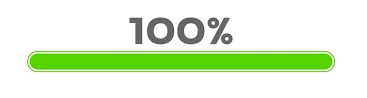

In [ ]:
from IPython.display import Image, display
display(Image(filename="....../completed.png")) # 🔹 add path to file